# Markov Chain / Quantumn Walk for Bike Simulation

Trial code. -Safa

In [38]:
import warnings
warnings.filterwarnings("ignore")

try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

import cirq_web
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [ ]:
# Define qubits
coin = cirq.LineQubit(0)        # 1 qubit for the coin
position = [cirq.LineQubit(1), cirq.LineQubit(2)]  # 2 qubits for position (3 stations)

# Create circuit
circuit = cirq.Circuit()

# Initialize position to station A (|00>)
circuit.append(cirq.ops.I(position[0]))
circuit.append(cirq.ops.I(position[1]))

# Apply Hadamard to create superposition in the coin
circuit.append(cirq.H(coin)) 

# TODO: Add cirq.KrausChannel for real world noise. 

# Define coin-controlled shift
def shift_operator():
    # This will conditionally increment or decrement position
    ops = []

    # If coin is |0> (move left), decrement station (00 -> 10, 01 -> 00, 10 -> 01)
    ops += [
        cirq.CNOT(coin, position[1]),  # simple mock logic for decrement
    ]
    # If coin is |1> (move right), increment station
    ops += [
        cirq.X(coin),
        cirq.CNOT(coin, position[0]),
        cirq.X(coin)
    ]

    return ops

# Add shift operator
circuit.append(shift_operator())

# Measure
circuit.append(cirq.measure(coin, key='coin'))
circuit.append(cirq.measure(*position, key='position'))

print(circuit)

0: ───H───@───X───@───X───────────────M('coin')───
          │       │
1: ───I───┼───────X───M('position')───────────────
          │           │
2: ───I───X───────────M───────────────────────────


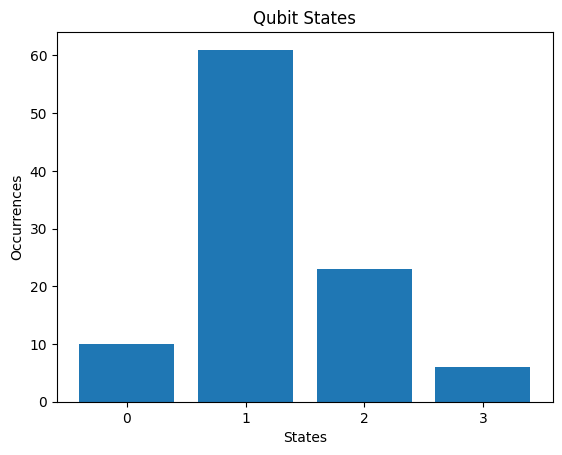

In [45]:
# Plot and simulation

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)

hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences')

plt.show()

result_counts = Counter(result.measurements['position'].astype(str).flatten())
print()


KeyError: np.str_('0')

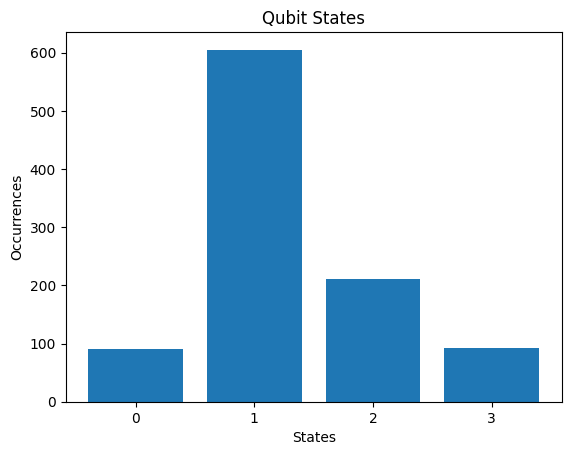

In [47]:
import cirq
import numpy as np

# 2 qubits to represent 4 stations
station = [cirq.LineQubit(0), cirq.LineQubit(1)]

# Define your transition matrix
P = np.array([
    [0.1, 0.6, 0.2, 0.1],
    [0.4, 0.1, 0.3, 0.2],
    [0.3, 0.2, 0.2, 0.3],
    [0.2, 0.2, 0.5, 0.1]
])

# Convert P into 4 Kraus operators
def build_kraus_ops(P):
    num_states = P.shape[0]
    ops = []
    for j in range(num_states):
        K = np.zeros((num_states, num_states))
        for i in range(num_states):
            K[j, i] = np.sqrt(P[i, j])  # note: transposed for correct direction
        ops.append(K)
    return ops

kraus_ops = build_kraus_ops(P)

# Wrap them as Cirq KrausChannel
kraus_channel = cirq.KrausChannel(kraus_ops)

# Build circuit
circuit = cirq.Circuit()

# Initialize in station A: |00⟩
circuit.append([cirq.I(station[0]), cirq.I(station[1])])

# Apply the channel
circuit.append(kraus_channel.on(*station))

# Measure
circuit.append(cirq.measure(*station, key='position'))

# Simulate
sim = cirq.DensityMatrixSimulator()
result = sim.run(circuit, repetitions=1000)
hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences')

# Map bits to station names
station_labels = {'00': 'A', '01': 'B', '10': 'C', '11': 'D'}
readable = {station_labels[k]: v for k, v in result_counts.items()}

print("Bike position distribution after 1 step:")
for s, c in readable.items():
    print(f"Station {s}: {c} bikes")
